In [1]:
import numpy as np
from math import factorial
from scipy.stats import chi2
import matplotlib.pyplot as plt  

In [2]:
def truncated_poisson_pmf(lam, m):
    """
    Return the normalised pmf P(i) ∝ λ^i / i!   for i = 0,…,m.
    """
    unnorm = np.array([lam**i / factorial(i) for i in range(m+1)], dtype=float)
    return unnorm / unnorm.sum()

def mh_trunc_poisson(lam, m, n_draw, burn_in=1000, seed=None):
    """
    Draw `n_draw` samples from the Poisson(λ) truncated at {0,…,m}
    using a simple ±1 Metropolis–Hastings chain.
    """
    rng = np.random.default_rng(seed)
    P   = truncated_poisson_pmf(lam, m)
    
    chain = np.empty(n_draw + burn_in, dtype=int)
    state = rng.integers(0, m+1)          # random start
    
    for t in range(n_draw + burn_in):
        # propose j = state ± 1, reflecting at the boundaries
        prop = state + rng.choice((-1, 1))
        if prop < 0 or prop > m:
            prop = state
        
        # MH acceptance
        if rng.random() < min(1.0, P[prop]/P[state]):
            state = prop
        
        chain[t] = state
    
    return chain[burn_in:]                # drop burn-in

def chi2_gof(counts, probs):
    """Return χ² statistic, p-value, and degrees-of-freedom."""
    n      = counts.sum()
    expect = n * probs
    stat   = ((counts - expect)**2 / expect).sum()
    dof    = len(counts) - 1              # no fitted params
    p_val  = 1 - chi2.cdf(stat, dof)
    return stat, p_val, dof

In [4]:
lam    = 12.3      # traffic intensity (same A as in Exercise 4)
m      = 20        # trunk capacity
Nkeep  = 50_000    # draws after burn-in
BURN   = 2_000
SEED   = 123

pmf    = truncated_poisson_pmf(lam, m)
sample = mh_trunc_poisson(lam, m, Nkeep, burn_in=BURN, seed=SEED)
counts = np.bincount(sample, minlength=m+1)

chi2_stat, chi2_p, dof = chi2_gof(counts, pmf)

print(f"λ = {lam},  m = {m}")
print(f"Sample size (post burn-in): {Nkeep:,}")
print(f"χ² statistic = {chi2_stat:.2f}  (d.o.f. = {dof})")
print(f"p-value      = {chi2_p:.4f}")
if chi2_p < 0.05:
    print("→ Reject truncated-Poisson at 5 % level")
else:
    print("→ Fail to reject (good fit)")

λ = 12.3,  m = 20
Sample size (post burn-in): 50,000
χ² statistic = 28.67  (d.o.f. = 20)
p-value      = 0.0945
→ Fail to reject (good fit)


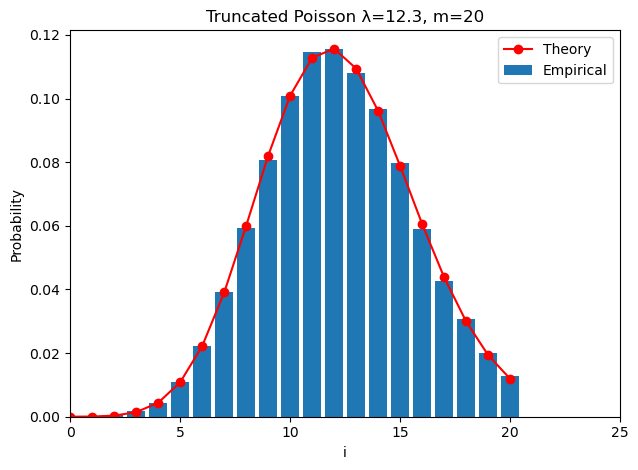

In [6]:
k = np.arange(m+1)
plt.bar(k, counts / Nkeep, width=0.8, label="Empirical")
plt.plot(k, pmf, "o-", color="red", label="Theory")
plt.xlabel("i"); plt.ylabel("Probability")
plt.title(f"Truncated Poisson λ={lam}, m={m}")
plt.legend(); plt.tight_layout()
plt.xlim(0,25)
plt.show()